In [32]:
library(dplyr)

In [33]:
setwd('/home/pzs2/TCGA')
options(stringsAsFactors = F)

#setwd('d:/Harvard/Lab/Peter/')
Clinicaldata=read.delim('clinical_PANCAN_patient_with_followup.tsv',stringsAsFactors = F)
#extract ID,survive info and censor info
Clinicaldata_sub=Clinicaldata[,c(2,5,7,8)]
#assemble data
Clinicaldata_sub[Clinicaldata_sub$vital_status=='Dead','vital_status']=1
Clinicaldata_sub[Clinicaldata_sub$vital_status=='Alive','vital_status']=0
Clinicaldata_sub$survive=NA
Clinicaldata_sub[Clinicaldata_sub$vital_status==1,'survive']<-
    Clinicaldata_sub[Clinicaldata_sub$vital_status==1,'days_to_death']
Clinicaldata_sub[Clinicaldata_sub$vital_status==0,'survive']<-
    Clinicaldata_sub[Clinicaldata_sub$vital_status==0,'days_to_last_followup']
Clinicaldata_sub$bcr_patient_barcode=gsub(pattern = '-',replacement = '.',
                                          Clinicaldata_sub$bcr_patient_barcode)
Clinicaldata_sub=Clinicaldata_sub[,c("bcr_patient_barcode","survive","vital_status")]
Clinicaldata_sub$survive=as.numeric(Clinicaldata_sub$survive)
Clinicaldata_sub$vital_status=as.numeric(Clinicaldata_sub$vital_status)


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [34]:
#read all gene markers and remove duplicates
genefile=list.files(pattern = '^genes')
genedata=lapply(genefile, read.table)
GeneMarkers.all=do.call(rbind,genedata)
GeneMarkers.all=GeneMarkers.all[!duplicated(GeneMarkers.all$V1),]

In [35]:
# using cox ph survival genes controlled for many different confounders not related to immune system
GeneMarkers.cox = read.table("pancancer.survival.genes.txt", sep="\t", header = T)
str(GeneMarkers.cox)
GeneMarkers.cox = GeneMarkers.cox %>% arrange(desc(abs(coef))) %>% head(n=nrow(.)*0.05)
GeneMarkers.cox = GeneMarkers.cox$genes
GeneMarkers.cox = GeneMarkers.cox[GeneMarkers.cox != "?"]
length(GeneMarkers.cox)

'data.frame':	19001 obs. of  8 variables:
 $ coef     : num  -0.07361 -0.11956 0.015 0.00193 -0.10469 ...
 $ exp.coef.: num  0.929 0.887 1.015 1.002 0.901 ...
 $ se.coef. : num  0.0263 0.03 0.0265 0.0252 0.0287 ...
 $ z        : num  -2.7942 -3.9806 0.5665 0.0764 -3.6458 ...
 $ Pr...z.. : num  5.20e-03 6.88e-05 5.71e-01 9.39e-01 2.67e-04 ...
 $ V6       : num  -6835 -6831 -6839 -6839 -6832 ...
 $ genes    : chr  "UBE2Q2P2" "?" "?" "EFCAB8" ...
 $ entrez   : int  100134869 280660 340602 388795 442388 90288 1 29974 54715 87769 ...


[1] 950

In [36]:
# using cytokines
GeneMarkers.cytokines = read.table("Cytokine_list.txt", sep="\t", header = F)
str(GeneMarkers.cytokines)
GeneMarkers.cytokines = GeneMarkers.cytokines[,1]
length(GeneMarkers.cytokines)

'data.frame':	230 obs. of  1 variable:
 $ V1: chr  "IL10RA" "IL10RB" "IL10" "IL11RA" ...


[1] 230

In [37]:
# using tide genes
GeneMarkers.tide = read.table("tide.genes.txt", sep="\t", skip=1, header = F)
str(GeneMarkers.tide)
GeneMarkers.tide = GeneMarkers.tide[,1]
length(GeneMarkers.tide)

'data.frame':	770 obs. of  3 variables:
 $ V1: chr  "BIN1" "PACSIN3" "RND3" "ARHGDIB" ...
 $ V2: num  1.522 -0.509 0.565 1.427 0.619 ...
 $ V3: num  -0.000182 1.692736 2.033305 -2.147408 1.585337 ...


[1] 770

In [38]:
# using all immune related genes (tide + cytokines + immune pathway)
GeneMarkers.all.immune = read.table("all.immune.genes.txt", sep="\t", header = F)
str(GeneMarkers.all.immune)
GeneMarkers.all.immune = GeneMarkers.all.immune[,1]
GeneMarkers.all.immune = unique(GeneMarkers.all.immune)
length(GeneMarkers.all.immune)

'data.frame':	1174 obs. of  1 variable:
 $ V1: chr  "PFN2" "IL32" "KRT1" "UPP1" ...


[1] 1096

In [39]:
GeneMarkers = GeneMarkers.all.immune

In [40]:
#expression data O2
Exprfile=list.files(pattern = '.rds')

Typename=gsub('_tpm.rds','',Exprfile)
Typename=gsub('TCGA_','',Typename)
Typename

[1] "ACC"  "BLCA" "BRCA" "CESC" "CHOL" "COAD" "DLBC" "ESCA" "GBM"  "HNSC"
[11] "KICH" "KIRC" "KIRP" "LAML" "LGG"  "LIHC" "LUAD" "LUSC" "MESO" "OV"  
[21] "PAAD" "PCPG" "PRAD" "READ" "SARC" "SKCM" "STAD" "TGCT" "THCA" "THYM"
[31] "UCEC" "UCS"  "UVM"

In [41]:
quantile_normalisation <- function(df){
  df_rank <- apply(df,2,rank,ties.method="min")
  df_sorted <- data.frame(apply(df, 2, sort))
  df_mean <- apply(df_sorted, 1, mean)
   
  index_to_mean <- function(my_index, my_mean){
    return(my_mean[my_index])
  }
   
  df_final <- apply(df_rank, 2, index_to_mean, my_mean=df_mean)
  rownames(df_final) <- rownames(df)
  return(df_final)
}

#test the function
df <- data.frame(one=c(5,2,3,4),
                 two=c(4,1,4,2),
                 three=c(3,4,6,8)
                 )
rownames(df) <- toupper(letters[1:4])
 
quantile_normalisation(df)

,one,two,three
A,5.666667,4.666667,2.000000
B,2.000000,2.000000,3.000000
C,3.000000,4.666667,4.666667
D,4.666667,3.000000,5.666667


In [42]:
Exprdata=lapply(Exprfile, readRDS)
Exprdata=lapply(Exprdata, t)

In [43]:
for (i in 1:length(Exprdata)) {
  Exprdata[[i]] = as.data.frame(Exprdata[[i]])
  Exprdata[[i]] = Exprdata[[i]][,colnames(Exprdata[[i]]) %in% GeneMarkers]
#   Exprdata[[i]] = quantile_normalisation(Exprdata[[i]])
  Exprdata[[i]]=data.frame(as.data.frame(Exprdata[[i]]),Type=as.character(Typename[i]))
  dim(Exprdata[[i]])
}
GeneExpr=do.call(rbind,Exprdata)
tail(colnames(GeneExpr))
dim(GeneExpr)

[1] "TNFRSF11A" "EPHB6"     "SOCS5"     "TIMP1"     "IL15RA"    "Type"

[1] 10912  1079

In [44]:
# remove genes with 0 expression
typelist <- GeneExpr$Type
medians <- apply(GeneExpr[,1:(ncol(GeneExpr)-1)], 2, median)
zero.medians <- which(medians == 0)
GeneExpr <- GeneExpr[, -zero.medians]
GeneExpr[,1:(ncol(GeneExpr)-1)] <- GeneExpr[,1:(ncol(GeneExpr)-1)] + 1
GeneExpr$Type <- typelist
tail(colnames(GeneExpr))
dim(GeneExpr)

[1] "TNFRSF11A" "EPHB6"     "SOCS5"     "TIMP1"     "IL15RA"    "Type"

[1] 10912  1051

In [45]:
sum(is.na(GeneExpr))

[1] 0

In [46]:
#all TCGA barcode is 16 in geneexpress data, but the dbarcode in clinical data is 12
GeneExpr$sample <- substr(rownames(GeneExpr),1,12)

Expr_ClinData <- left_join(GeneExpr,Clinicaldata_sub,by=c('sample' = 'bcr_patient_barcode'))
dim(Expr_ClinData)
tail(colnames(Expr_ClinData))
head(colnames(Expr_ClinData))

[1] 10912  1054

[1] "TIMP1"        "IL15RA"       "Type"         "sample"       "survive"     
[6] "vital_status"

[1] "PFN2"   "IL32"   "KRT1"   "UPP1"   "KCNE4"  "FCGR2B"

In [47]:
# remove rows with no survival information
data <- Expr_ClinData[!is.na(Expr_ClinData[,'survive']),]
dim(data)

[1] 10815  1054

In [48]:
# normalize survival for each cancer type
data <- data %>% 
    group_by(Type) %>% 
    mutate(survive = (survive / max(survive, na.rm=T)))

In [49]:
# for GSEA
# gsea <- 

In [50]:
# scale between 0-1000 for survival days to see if it can fix gradients
# data$survive <- data$survive*1000

In [51]:
# remove not needed columns
data <- data[, -which(names(data) %in% c("sample","Type"))]

In [52]:
dim(data)

[1] 10815  1052

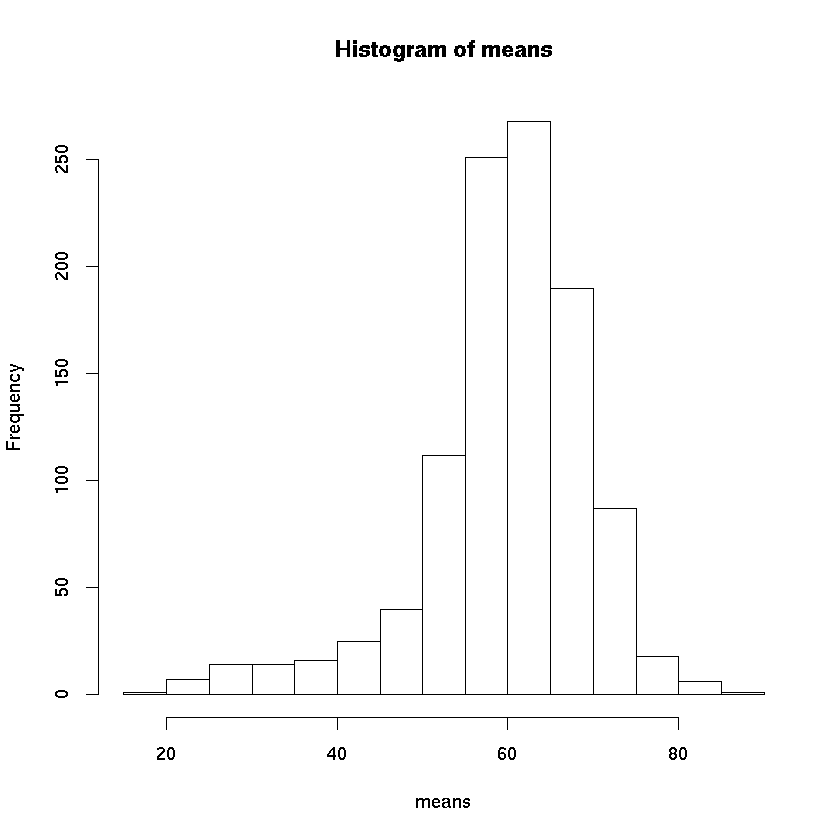

In [53]:
means <- apply(data[1:(ncol(data)-2)], 2, mean)
hist(means)

In [54]:
# write.table(data,file = 'Expr_ClinData_marker_normalized.txt',sep = '\t')

In [55]:
TrainingData=sample(1:nrow(data),replace = F,size = 0.8*nrow(data))
tmp=setdiff(1:nrow(data),TrainingData)
TestData=sample(tmp,replace = F,size =0.1*nrow(data))
EvalData=setdiff(tmp,TestData)
TrainingData=data[TrainingData,]
TestData=data[TestData,]
EvalData=data[EvalData,]

savepath = '/home/pzs2/capstone/proj/TCGA_LiuLab/pancancer_all_immune/'

write.table(EvalData,file = paste0(savepath,'EvalData.txt'),sep = '\t', row.names = F, quote = F)
write.table(TestData,file = paste0(savepath,'TestData.txt'),sep = '\t',row.names = F, quote = F)
write.table(TrainingData,file = paste0(savepath,'TrainingData.txt'),sep = '\t',row.names = F, quote = F)
genes <- colnames(data)
genes <- genes[1:(length(genes) -2)]
write.table(genes, file=paste0(savepath,'geneset.txt'),row.names = F, quote = F)